In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<string>:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.


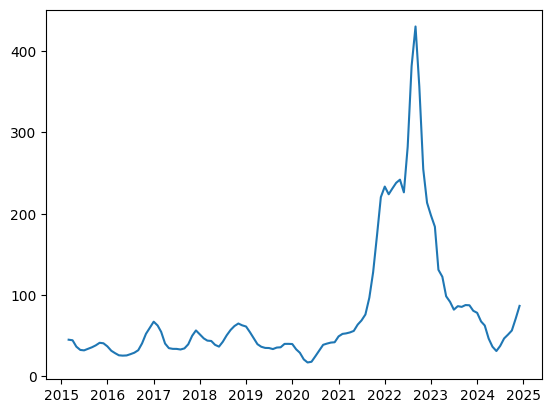

In [8]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_att import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [11]:
X_past_train = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_train.npy'))
X_future_train = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_train.npy'))
X_past_val = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_val.npy'))
X_future_val = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_val.npy'))
X_past_test = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_test.npy'))
X_future_test = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_test.npy'))

X_past_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_train_transformed.npy'))
X_future_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_train_transformed.npy'))
X_past_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_val_transformed.npy'))
X_future_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_val_transformed.npy'))
X_past_test_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_test_transformed.npy'))
X_future_test_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_test_transformed.npy'))
y_train = np.load(os.path.join(DATA_PATH, 'ATT', 'y_train.npy'))
y_val = np.load(os.path.join(DATA_PATH, 'ATT', 'y_val.npy'))
y_test = np.load(os.path.join(DATA_PATH, 'ATT', 'y_test.npy'))

train_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'train_times.pkl'))
val_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'val_times.pkl'))
test_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'test_times.pkl'))


In [12]:
train_times.max(), train_times.min()

(Timestamp('2020-03-12 00:00:00+0100', tz='Europe/Paris'),
 Timestamp('2015-01-12 00:00:00+0100', tz='Europe/Paris'))

In [13]:
val_times.max(), val_times.min()

(Timestamp('2023-09-21 00:00:00+0200', tz='Europe/Paris'),
 Timestamp('2020-04-05 00:00:00+0200', tz='Europe/Paris'))

In [14]:
test_times.max(), test_times.min()

(Timestamp('2024-12-30 00:00:00+0100', tz='Europe/Paris'),
 Timestamp('2023-09-29 00:00:00+0200', tz='Europe/Paris'))

In [15]:
train_times.shape, val_times.shape, test_times.shape

((1101,), (367,), (355,))

# 2. Forecast with ATT

In [4]:
from scripts.model_att import AttentionModel

att_model = AttentionModel(
    # CNN parameters
    cnn_filters=64,        # Increased to capture more complex patterns
                          # Start with more filters since we have 21 input features
    
    # LSTM parameters
    lstm_units=128,       # Increased to handle complex temporal dependencies
                         # Rule of thumb: 2-4x input features
    
    # Attention parameters
    attention_heads=8,    # Increased to capture different aspects of the sequence
                         # Rule of thumb: sequence_length / 32 ≈ 5-8
    attention_key_dim=64, # Typically key_dim = filters/heads for stable training
                         # 64/8 = 8 dimensions per head
    
    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],   # From X_past_train_transformed.shape[2]
    n_future_features=X_future_train_transformed.shape[2], # From X_future_train_transformed.shape[2]
    past_seq_len=X_past_train_transformed.shape[1],     # From X_past_train_transformed.shape[1]
    future_seq_len=X_future_train_transformed.shape[1],    # From X_future_train_transformed.shape[1]
    
    # Regularization
    dropout=0,          # Slightly reduced to prevent underfitting
                         # Since we have batch_normalization
    batch_normalization=True,
    
    # Training parameters
    learning_rate=0.001,  # Good starting point for Adam
    verbose=True,
    epochs_early_stopping=40,  # Increased to allow better convergence
                              # Given the model complexity
    
    # Loss and metrics
    loss='mse',          # Appropriate for regression
    metrics=['mae'],     # Consider adding 'mape' for percentage error
    
    # Additional regularization
    regularization='l2', # Added L2 regularization
    lambda_reg=0     # Small L2 penalty to prevent overfitting
)

att_model

2025-08-18 14:48:17.243837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 14:48:17.245064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 14:48:17.251799: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 14:48:17.262830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755521297.279998   89042 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755521297.28

In [5]:
att_model.fit(X_past_train_transformed, X_future_train_transformed, y_train, 
            X_past_val_transformed, X_future_val_transformed, y_val)


Epoch 1/1000


2025-08-18 14:48:28.220097: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


345/345 ━━━━━━━━━━━━━━━━━━━━ 143s 390ms/step - loss: 488.4499 - mae: 15.3691 - val_loss: 750.2042 - val_mae: 18.6157
Epoch 2/1000
345/345 ━━━━━━━━━━━━━━━━━━━━ 104s 302ms/step - loss: 180.2247 - mae: 7.2525 - val_loss: 614.3602 - val_mae: 16.1037
Epoch 3/1000
345/345 ━━━━━━━━━━━━━━━━━━━━ 109s 317ms/step - loss: 126.6314 - mae: 6.8267 - val_loss: 500.4696 - val_mae: 13.9681
Epoch 4/1000
174/345 ━━━━━━━━━━━━━━━━━━━━ 1:14 436ms/step - loss: 315.4271 - mae: 11.2792

KeyboardInterrupt: 

In [ ]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/ATT/fit

Launching TensorBoard...

In [18]:
from scripts.model_att import AttentionModel
model_name = "20250820-135126"

att_model = AttentionModel.from_saved_model(model_name)

att_model

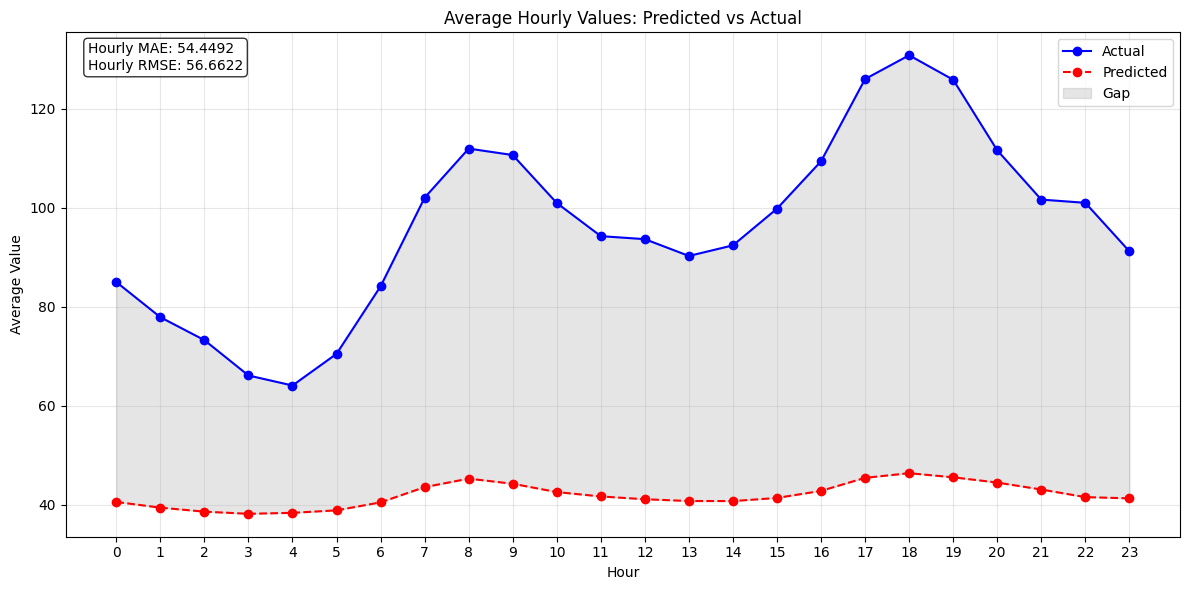

In [20]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

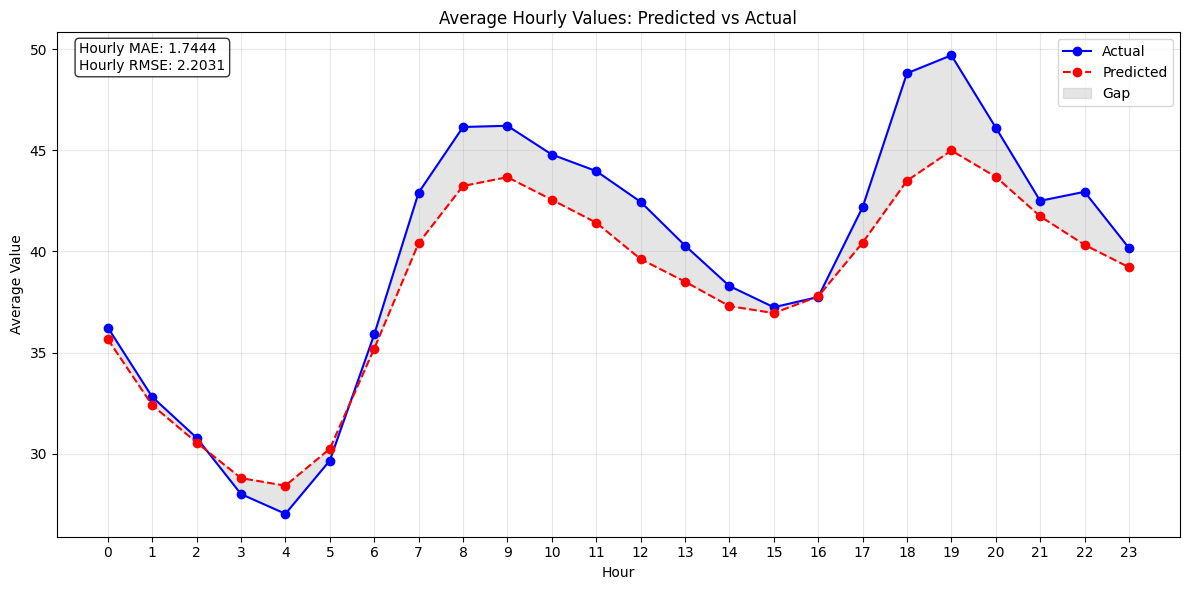

In [21]:
pred = att_model.predict(X_past_train_transformed, X_future_train_transformed)

att_model.plot_hourly_averages(y_train, pred)